<a href="https://colab.research.google.com/github/somilasthana/deeplearningtutorial/blob/master/NLP_Tensorflow_LSTM_Text_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.regularizers import l2

import tensorflow as tf
import tensorflow.keras.utils as ku
import numpy as np


In [0]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

--2019-06-25 01:50:50--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.218.128, 2a00:1450:4013:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.218.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2019-06-25 01:50:50 (93.9 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [0]:
corpus = data.lower().split("\n")
tokenizer = Tokenizer()

tokenizer.fit_on_texts(corpus)

In [0]:
total_words = len(tokenizer.word_index) + 1

In [0]:
# create input sequences using list of tokens

input_sequence = []
for line in corpus:
  token_list = tokenizer.texts_to_sequences([line])[0]
  
  for i in range(1, len(token_list)):
    n_gram_sequences = token_list[:i+1]
    input_sequence.append(n_gram_sequences)

In [7]:
max_sequence_len = max([len(x) for x in input_sequence])
max_sequence_len

11

In [0]:
input_sequence = np.array(
    pad_sequences(input_sequence, maxlen=max_sequence_len, padding='pre')
)

In [9]:
predictors, labels = input_sequence[:, :-1], input_sequence[:, -1]
predictors.shape, labels.shape

((15462, 10), (15462,))

In [0]:
labels = ku.to_categorical(labels, num_classes=total_words)

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(total_words, 100, input_length=max_sequence_len-1),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(1e-3)),
    tf.keras.layers.Dense(total_words, activation='softmax')
])

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 10, 100)           321100    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 10, 128)           84480     
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 128)           0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 3211)              208715    
Total params: 659,671
Trainable params: 659,671
Non-trainable params: 0
________________________________________________

In [0]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(0.01), metrics=["accuracy"])

In [27]:
history = model.fit(predictors, labels, epochs=100, verbose=2)

W0625 02:16:54.894635 140527551022976 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 15462 samples
Epoch 1/100
15462/15462 - 29s - loss: 6.8211 - accuracy: 0.0216
Epoch 2/100
15462/15462 - 26s - loss: 6.4850 - accuracy: 0.0234
Epoch 3/100
15462/15462 - 26s - loss: 6.4096 - accuracy: 0.0292
Epoch 4/100
15462/15462 - 25s - loss: 6.3499 - accuracy: 0.0321
Epoch 5/100
15462/15462 - 26s - loss: 6.3154 - accuracy: 0.0333
Epoch 6/100
15462/15462 - 26s - loss: 6.2725 - accuracy: 0.0347
Epoch 7/100
15462/15462 - 26s - loss: 6.2408 - accuracy: 0.0346
Epoch 8/100
15462/15462 - 26s - loss: 6.2031 - accuracy: 0.0376
Epoch 9/100
15462/15462 - 26s - loss: 6.1601 - accuracy: 0.0418
Epoch 10/100
15462/15462 - 26s - loss: 6.1159 - accuracy: 0.0417
Epoch 11/100
15462/15462 - 26s - loss: 6.0790 - accuracy: 0.0434
Epoch 12/100
15462/15462 - 25s - loss: 6.0332 - accuracy: 0.0442
Epoch 13/100
15462/15462 - 26s - loss: 6.0017 - accuracy: 0.0465
Epoch 14/100
15462/15462 - 26s - loss: 5.9641 - accuracy: 0.0483
Epoch 15/100
15462/15462 - 26s - loss: 5.9383 - accuracy: 0.0472
Epoch 16/10

In [30]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

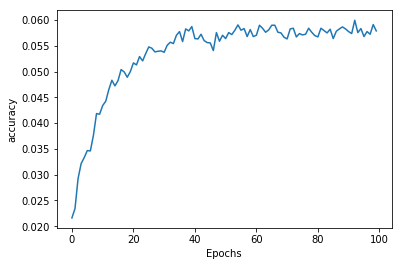

In [32]:
plot_graphs(history, "accuracy")

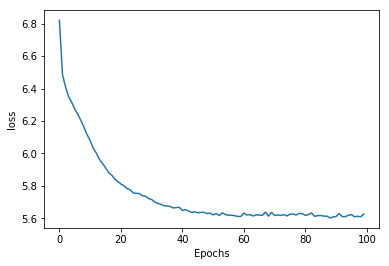

In [33]:
plot_graphs(history, "loss")

In [39]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100

for _ in range(next_words):
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
  pred = model.predict_classes(token_list, verbose=0)
  outword = ""
  for word, index in tokenizer.word_index.items():
    if index == pred:
      output_word = word
      break
  seed_text += " " + output_word

print(seed_text)

Help me Obi Wan Kenobi, you're my only hope in the world of my love with ' ' ' ' art ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' '
